In [1]:
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [2]:
import seaborn as sns
import numpy as np 
from collections import Counter

In [3]:
path = URLs.path('titanic')
path

Path('/home/teeth/.fastai/archive/titanic')

In [4]:
Path.BASE_PATH = path
if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli('titanic', path=path)
    file_extract(path/'titanic.zip')

In [5]:
path.ls()

(#4) [Path('gender_submission.csv'),Path('test.csv'),Path('titanic.zip'),Path('train.csv')]

In [6]:
tdf = pd.read_csv(path/'train.csv', low_memory=False)
tedf = pd.read_csv(path/'test.csv', low_memory=False)

In [7]:
tdf.head()

,PassengerId,Survived,Pclass,Name,...,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",...,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",...,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",...,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",...,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",...,373450,8.0500,NaN,S


In [8]:
tdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
tdf.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
def outlier_detect(feature, data):
    outlier_index = []

    for each in feature:
        Q1 = np.percentile(data[each], 25)
        Q3 = np.percentile(data[each], 75)
        IQR = Q3 - Q1
        min_quartile = Q1 - 1.5*IQR
        max_quartile = Q3 + 1.5*IQR
        outlier_list = data[(data[each] < min_quartile) | (data[each] > max_quartile)].index
        outlier_index.extend(outlier_list)
        
    outlier_index = Counter(outlier_index)
    #If there are three or more outlier data features we must delete them. (n)
    outlier_data = list(i for i, n in outlier_index.items() if n > 3)
    return outlier_data

In [11]:
outlier_data = outlier_detect(["Age","SibSp","Parch","Fare"], tdf)
tdf.loc[outlier_data] #No Outliers!

,PassengerId,Survived,Pclass,Name,...,Ticket,Fare,Cabin,Embarked


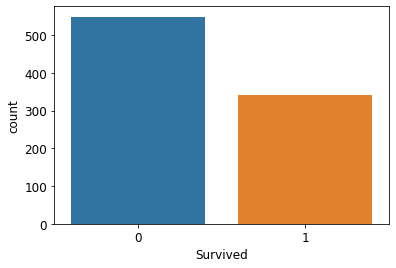

In [12]:
sns.countplot(x='Survived',data=tdf);

In [13]:
data = pd.concat([tdf, tedf], axis=0).reset_index(drop=True)

In [14]:
data[['Sex', 'Survived']].groupby(['Sex'], as_index = False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


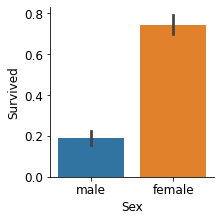

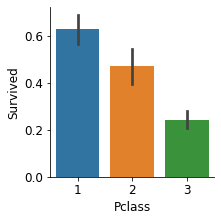

In [15]:
sns.catplot(x="Sex", y ="Survived", data=data, kind="bar", height=3)
sns.catplot(x="Pclass", y ="Survived", data=data, kind="bar", height=3)
plt.show()

In [16]:
#data["Sex"] = [0 if i == "male" else 1 for i in data["Sex"]]
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
# male: 0, female: 1

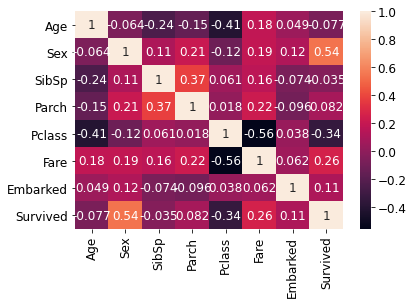

In [17]:
sns.heatmap(data[["Age","Sex","SibSp","Parch","Pclass","Fare","Embarked", "Survived"]].corr(), annot = True)
plt.show()

In [18]:
data.columns[data.isnull().any()]

Index(['Survived', 'Age', 'Fare', 'Cabin', 'Embarked'], dtype='object')

In [19]:
data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [20]:
data[data['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,...,Ticket,Fare,Cabin,Embarked
1043,1044,NaN,3,"Storey, Mr. Thomas",...,3701,NaN,NaN,0.0


In [21]:
fare_mean = np.mean(
    data[(
        (data["Pclass"]==3) 
          & (data["Embarked"]==0)
         )]["Fare"]
)
data["Fare"] = data["Fare"].fillna(fare_mean)
data[data["Fare"].isnull()]

,PassengerId,Survived,Pclass,Name,...,Ticket,Fare,Cabin,Embarked


In [22]:
data[data["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,...,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",...,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",...,113572,80.0,B28,NaN


In [23]:
data["Embarked"] = data["Embarked"].fillna(1)
data[data["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,...,Ticket,Fare,Cabin,Embarked


In [37]:
data[data["Age"].isnull()]

,PassengerId,Survived,Pclass,Name,...,Family,Alone,Title,Age_Limit
5,6,0.0,3,"Moran, Mr. James",...,0,1,1,NaN
17,18,1.0,2,"Williams, Mr. Charles Eugene",...,0,1,1,NaN
19,20,1.0,3,"Masselmani, Mrs. Fatima",...,0,1,2,NaN
26,27,0.0,3,"Emir, Mr. Farred Chehab",...,0,1,1,NaN
28,29,1.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",...,0,1,2,NaN
...,...,...,...,...,...,...,...,...,...
1299,1300,NaN,3,"Riordan, Miss. Johanna Hannah""""",...,0,1,2,NaN
1301,1302,NaN,3,"Naughton, Miss. Hannah",...,0,1,2,NaN
1304,1305,NaN,3,"Spector, Mr. Woolf",...,0,1,1,NaN
1307,1308,NaN,3,"Ware, Mr. Frederick",...,0,1,1,NaN


In [38]:
data_age_nan_index = data[data["Age"].isnull()].index
for i in data_age_nan_index:
    passanger_class = data.iloc[i]["Pclass"]
    mean_age = data["Age"][(data["Pclass"]==passanger_class)].median()
    data.iloc[i, data.columns.get_loc("Age")] = mean_age
    

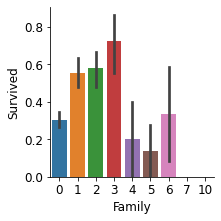

In [39]:
data["Family"] = data["SibSp"] + data["Parch"]
sns.catplot(x="Family", y ="Survived", data=data, kind="bar", height=3)
plt.show()

In [40]:
data[['Family', "Survived"]]

,Family,Survived
0,1,0.0
1,1,1.0
2,0,1.0
3,1,1.0
4,0,0.0
...,...,...
1304,0,NaN
1305,0,NaN
1306,0,NaN
1307,0,NaN


In [41]:
data["Alone"] = [1 if i == 0 else 0 for i in data["Family"]]
data["Family"].replace([0,1,2,3,4,5,6,7,10], [0,1,1,1,0,2,0,2,2], inplace=True)
data.head()

,PassengerId,Survived,Pclass,Name,...,Family,Alone,Title,Age_Limit
0,1,0.0,3,"Braund, Mr. Owen Harris",...,1,0,1,"(16.136, 32.102]"
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",...,1,0,2,"(32.102, 48.068]"
2,3,1.0,3,"Heikkinen, Miss. Laina",...,0,1,2,"(16.136, 32.102]"
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",...,1,0,2,"(32.102, 48.068]"
4,5,0.0,3,"Allen, Mr. William Henry",...,0,1,1,"(32.102, 48.068]"


In [42]:
data['Title']=data.Name.str.extract('([A-Za-z]+)\.')

In [43]:
data['Title'].replace(['Mme','Ms','Mlle','Lady','Countess','Dona','Dr','Major','Sir','Capt','Don','Rev','Col', 'Jonkheer'],['Miss','Miss','Miss','Mrs','Mrs','Mrs','Mr','Mr','Mr','Mr','Mr','Other','Other','Other'], inplace=True)

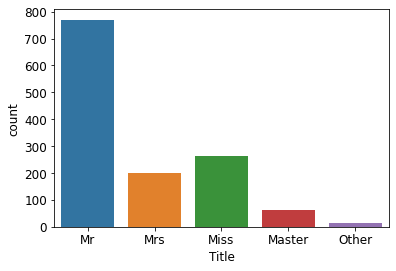

In [44]:
sns.countplot(x=data["Title"])
plt.show()

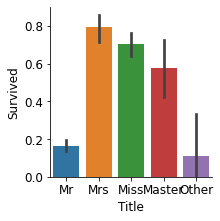

In [45]:
sns.catplot(x="Title", y ="Survived", data=data, kind="bar", height=3)
plt.show()

In [46]:
data["Title"].replace(["Mr","Mrs","Miss","Master","Other"], [1,2,2,3,1], inplace=True)

In [47]:
data['Age_Limit']=pd.cut(data['Age'], 5)
data.groupby(['Age_Limit'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Age_Limit,
"(0.0902, 16.136]",0.550000
"(16.136, 32.102]",0.336714
"(32.102, 48.068]",0.412844
"(48.068, 64.034]",0.434783
"(64.034, 80.0]",0.090909


In [48]:
data['Age_Limit'] = LabelEncoder().fit_transform(data['Age_Limit'])

In [49]:
data['Fare_Limit']=pd.qcut(data['Fare'],4)
data.groupby(['Fare_Limit'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Fare_Limit,
"(-0.001, 7.896]",0.197309
"(7.896, 14.454]",0.303571
"(14.454, 31.275]",0.441048
"(31.275, 512.329]",0.600000


In [50]:
data['Fare_Limit'] = LabelEncoder().fit_transform(data['Fare_Limit'])

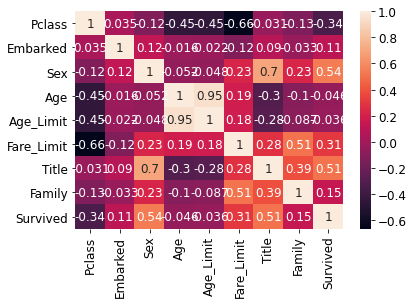

In [51]:
sns.heatmap(data[["Cabin","Pclass","Embarked","Sex","Age","Age_Limit","Fare_Limit", "Title","Family", "Survived"]].corr(), annot = True)
plt.show()

In [52]:
data['Age']=data['Age'].astype(int)

data.drop(labels=["SibSp","Parch","Cabin","Fare","Age", "Ticket", "Name", "PassengerId"], axis=1, inplace = True)
data.head()

,Survived,Pclass,Sex,Embarked,...,Alone,Title,Age_Limit,Fare_Limit
0,0.0,3,0,0.0,...,0,1,1,0
1,1.0,1,1,1.0,...,0,2,2,3
2,1.0,3,1,0.0,...,1,2,1,1
3,1.0,1,1,0.0,...,0,2,2,3
4,0.0,3,0,0.0,...,1,1,2,1


In [53]:
data = pd.get_dummies(data,columns=["Pclass"])
data = pd.get_dummies(data,columns=["Embarked"])
data = pd.get_dummies(data,columns=["Family"])
data = pd.get_dummies(data,columns=["Age_Limit"])
data = pd.get_dummies(data,columns=["Fare_Limit"])
data = pd.get_dummies(data,columns=["Title"])

data.head()

,Survived,Sex,Alone,Pclass_1,...,Fare_Limit_3,Title_1,Title_2,Title_3
0,0.0,0,0,0,...,0,1,0,0
1,1.0,1,0,1,...,1,0,1,0
2,1.0,1,1,0,...,0,0,1,0
3,1.0,1,0,1,...,1,0,1,0
4,0.0,0,1,0,...,0,1,0,0


In [152]:
data["Pclass_1"].head()

0    0
1    1
2    0
3    1
4    0
Name: Pclass_1, dtype: uint8

In [55]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [67]:
test = data[len(tedf):]
test = test.drop(labels="Survived", axis=1)

In [68]:
test.columns

Index(['Sex', 'Alone', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_0.0',
       'Embarked_1.0', 'Embarked_2.0', 'Family_0', 'Family_1', 'Family_2',
       'Age_Limit_0', 'Age_Limit_1', 'Age_Limit_2', 'Age_Limit_3',
       'Age_Limit_4', 'Fare_Limit_0', 'Fare_Limit_1', 'Fare_Limit_2',
       'Fare_Limit_3', 'Title_1', 'Title_2', 'Title_3'],
      dtype='object')

In [69]:
train = data[:len(tdf)]
X_train = train.drop(labels = "Survived", axis=1)
y_train = train["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [70]:
rf_reg = RandomForestClassifier(random_state=42)
rf_reg.fit(X_train, y_train)
print("Accuracy: ", rf_reg.score(X_test,y_test))

Accuracy:  0.8134328358208955


### Neural Net

In [71]:
cont, cat = cont_cat_split(train, 1, dep_var = 'Survived')
cont, cat

(['Sex', 'Alone'],
 ['Pclass_1',
  'Pclass_2',
  'Pclass_3',
  'Embarked_0.0',
  'Embarked_1.0',
  'Embarked_2.0',
  'Family_0',
  'Family_1',
  'Family_2',
  'Age_Limit_0',
  'Age_Limit_1',
  'Age_Limit_2',
  'Age_Limit_3',
  'Age_Limit_4',
  'Fare_Limit_0',
  'Fare_Limit_1',
  'Fare_Limit_2',
  'Fare_Limit_3',
  'Title_1',
  'Title_2',
  'Title_3'])

In [155]:
all_columns = cont + cat
all_columns

['Sex',
 'Alone',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Embarked_0.0',
 'Embarked_1.0',
 'Embarked_2.0',
 'Family_0',
 'Family_1',
 'Family_2',
 'Age_Limit_0',
 'Age_Limit_1',
 'Age_Limit_2',
 'Age_Limit_3',
 'Age_Limit_4',
 'Fare_Limit_0',
 'Fare_Limit_1',
 'Fare_Limit_2',
 'Fare_Limit_3',
 'Title_1',
 'Title_2',
 'Title_3']

In [74]:
procs_nn = [Categorify, FillMissing, Normalize]
to = TabularPandas(train, procs_nn, cont + cat, [],
                        splits = RandomSplitter()(range_of(test)),
                        y_names='Survived'
                     )
dls = to.dataloaders(64)

In [81]:
learn = tabular_learner(dls, y_range=(0,1), layers=[1024, 512], n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.0003981071640737355)

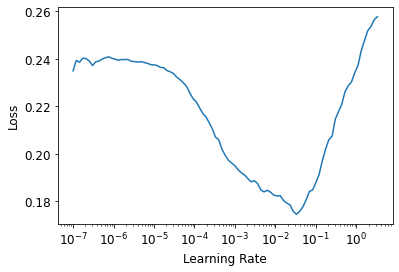

In [82]:
learn.lr_find()

In [85]:
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,time
0,0.111746,0.120620,00:00
1,0.113508,0.131016,00:00


In [150]:
list(learn.model.children())

[ModuleList(
   (0): Embedding(3, 3)
   (1): Embedding(3, 3)
   (2): Embedding(3, 3)
   (3): Embedding(3, 3)
   (4): Embedding(3, 3)
   (5): Embedding(3, 3)
   (6): Embedding(3, 3)
   (7): Embedding(3, 3)
   (8): Embedding(3, 3)
   (9): Embedding(3, 3)
   (10): Embedding(3, 3)
   (11): Embedding(3, 3)
   (12): Embedding(3, 3)
   (13): Embedding(3, 3)
   (14): Embedding(3, 3)
   (15): Embedding(3, 3)
   (16): Embedding(3, 3)
   (17): Embedding(3, 3)
   (18): Embedding(3, 3)
   (19): Embedding(3, 3)
   (20): Embedding(3, 3)
   (21): Embedding(3, 3)
   (22): Embedding(3, 3)
 ),
 Dropout(p=0.0, inplace=False),
 BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Sequential(
   (0): LinBnDrop(
     (0): BatchNorm1d(69, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (1): Linear(in_features=69, out_features=1024, bias=False)
     (2): ReLU(inplace=True)
   )
   (1): LinBnDrop(
     (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, 

In [141]:
learn.model.embeds[0].weight

Parameter containing:
tensor([[ 0.0068, -0.0076,  0.0003],
        [-0.0037,  0.0105, -0.0055],
        [-0.0210, -0.0013,  0.0024]], device='cuda:0', requires_grad=True)

In [163]:
torch.tensor(data[column]).cuda()

tensor([0, 1, 1,  ..., 0, 0, 0], device='cuda:0')

In [226]:
data_e = pd.DataFrame()
with torch.no_grad():
    for i, column_name in enumerate(all_columns):
        data_column_tensor = torch.tensor(data[column]).cuda()
        e_matrix = learn.model.embeds[i]
        embedding = e_matrix(data_column_tensor).cpu()
        for e_i in range(3):
            data_e[f'{column_name}_{e_i}'] = embedding[:,e_i]
#     data_e[column_name] = learn.model.embeds[0](column_tensor).item()
#     print(learn.model.embeds[0])

In [212]:
learn.model.embeds[0](column_tensor)

tensor([[ 0.0068, -0.0076,  0.0003],
        [-0.0037,  0.0105, -0.0055],
        [-0.0037,  0.0105, -0.0055],
        ...,
        [ 0.0068, -0.0076,  0.0003],
        [ 0.0068, -0.0076,  0.0003],
        [ 0.0068, -0.0076,  0.0003]], device='cuda:0', grad_fn=<EmbeddingBackward>)

In [222]:
data_e["Sex"] = learn.model.embeds[0](column_tensor)[:,2].cpu().detach().numpy()

In [309]:
len(data_e.columns)

69

In [317]:
train = data_e[:len(tdf)]
# X_train = train.drop(labels = "Survived", axis=1)
X_train, X_test, y_train, y_test = train_test_split(train, y_train, test_size=0.3, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [891, 213]

In [315]:
X_train.shape

(213, 23)

In [252]:
y_train.shape

(436,)

In [302]:
rf_reg = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=40)
rf_reg.fit(X_train, y_train)
rf_reg.predict(X_test).shape, y_test.shape
# print("Accuracy: ", F.mse_loss(,y_test))
pred = rf_reg.predict(X_test)
# r_mse(pred, y_test)
nn.MSELoss()(torch.tensor(pred), torch.tensor(y_test.to_numpy()))

tensor(0.2086, dtype=torch.float64)

In [303]:
test = data_e[len(tdf):]

In [308]:
X_train.shape, test.shape

((436, 23), (418, 69))

In [306]:
pred_t = rf_reg.predict(X_test)

### This is how you better extract embeddings from neural net and put into dataframe

In [ ]:
def embed_features(learner, xs):
    xs = xs.copy()
    for i, feature in enumerate(learn.dls.cat_names):
        emb = learner.model.embeds[i]
        evaluated_embeddings = emb(tensor(xs[feature], dtype=torch.int64))
        new_feat = pd.DataFrame(evaluated_embeddings, index=xs.index, columns=[f'{feature}_{j}' for j in range(emb.embedding_dim)])
        xs.drop(columns=feature, inplace=True)
        xs = xs.join(new_feat)
    return xs

In [ ]:
nn.Embedding(3, 3).embedding_dim